# Initialisations

In [1]:
import torch as pt
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms
import torchvision

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,color
from math import exp
import scipy as sc
from scipy.sparse.linalg import eigsh

In [3]:
from skimage.color import rgba2rgb

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# look up table
PASCAL_VOC_CLASSES_COLORS = {
    0: (0, 0, 0),        # Background
    1: (128, 0, 0),      # Aeroplane
    2: (0, 128, 0),      # Bicycle
    3: (128, 128, 0),    # Bird
    4: (0, 0, 128),      # Boat
    5: (128, 0, 128),    # Bottle
    6: (0, 128, 128),    # Bus
    7: (128, 128, 128),  # Car
    8: (64, 0, 0),       # Cat
    9: (192, 0, 0),      # Chair
    10: (64, 128, 0),    # Cow
    11: (192, 128, 0),   # Diningtable
    12: (64, 0, 128),    # Dog
    13: (192, 0, 128),   # Horse
    14: (64, 128, 128),  # Motorbike
    15: (192, 128, 128), # Person
    16: (0, 64, 0),      # Potted plant
    17: (128, 64, 0),    # Sheep
    18: (0, 192, 0),     # Sofa
    19: (128, 192, 0),   # Train
    20: (0, 64, 128)     # TV/Monitor
}

In [6]:
# from PIL import Image

!pip install -q torchinfo
from torchinfo import summary

In [7]:
# Test dataset already made in previous part

In [8]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop([256, 256])
])

In [9]:
# #im = train_image_files[0]
# #print(im.shape)
# # im =preprocess(im)
# im.shape
# #plt.imshow(im)


# Training Dataset

Loading data from folder in drive

In [10]:
with open("/content/drive/MyDrive/PascalVOC/trainval/train.txt") as file:
  valid_indices = [line.strip() for line in file]

In [11]:
folder = "/content/drive/MyDrive/PascalVOC/trainval/Images"
file_names = sorted(os.listdir(folder))
file_paths = [os.path.join(folder, file_name) for file_name in file_names]

In [12]:
filtered_file_paths = []
for file_path in file_paths:
    base_name, ext = os.path.splitext(os.path.basename(file_path))
    if base_name in valid_indices:
        filtered_file_paths.append(file_path)

In [13]:
train_image_files = [io.imread(image_path) for image_path in filtered_file_paths]

In [14]:
len(train_image_files)

209

In [15]:
folder = "/content/drive/MyDrive/PascalVOC/trainval/Annotations"
annot_names = sorted(os.listdir(folder))
annot_paths = [os.path.join(folder, annot_name) for annot_name in annot_names]

In [16]:
filtered_annot_paths = []
for annot_path in annot_paths:
    base_name, ext = os.path.splitext(os.path.basename(annot_path))
    if base_name in valid_indices:
        filtered_annot_paths.append(annot_path)

In [17]:
train_annot_files = [io.imread(annot_path) for annot_path in filtered_annot_paths]

In [18]:

len(train_annot_files)

209

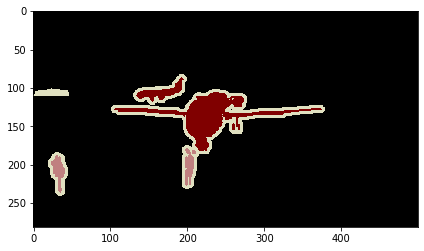

In [19]:
io.imshow(train_annot_files[0])

# Validation dataset

Loading data from folder in drive

In [58]:
with open("/content/drive/MyDrive/PascalVOC/trainval/val.txt") as file:
  valid_indices = [line.strip() for line in file]

In [59]:
folder = "/content/drive/MyDrive/PascalVOC/trainval/Images"
file_names = sorted(os.listdir(folder))
file_paths = [os.path.join(folder, file_name) for file_name in file_names]

In [60]:
filtered_file_paths = []
for file_path in file_paths:
    base_name, ext = os.path.splitext(os.path.basename(file_path))
    if base_name in valid_indices:
        filtered_file_paths.append(file_path)

In [61]:
val_image_files = [io.imread(image_path) for image_path in filtered_file_paths]

In [62]:
len(val_image_files)

213

In [63]:
folder = "/content/drive/MyDrive/PascalVOC/trainval/Annotations"
annot_names = sorted(os.listdir(folder))
annot_paths = [os.path.join(folder, annot_name) for annot_name in annot_names]

In [64]:
filtered_annot_paths = []
for annot_path in annot_paths:
    base_name, ext = os.path.splitext(os.path.basename(annot_path))
    if base_name in valid_indices:
        filtered_annot_paths.append(annot_path)

In [65]:
val_annot_files = [io.imread(annot_path) for annot_path in filtered_annot_paths]

In [66]:
len(val_annot_files)

213

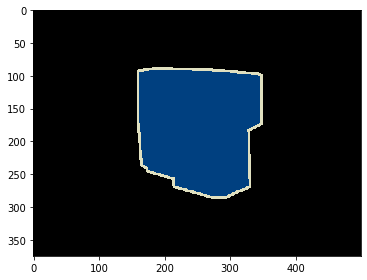

In [67]:
io.imshow(val_annot_files[0])

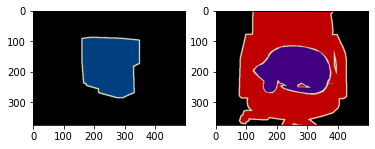

In [68]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(val_annot_files[0])
axarr[1].imshow(val_annot_files[1])

# Train and Validation dataloaders 

In [31]:
#Custom dataset
class train_SegmentationDataset(Dataset):
    def __init__(self, image_files, annotation_files, lookup_table, transform=None):
        self.image_files = image_files
        self.annotation_files = annotation_files
        self.lookup_table = lookup_table
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self.image_files[idx]
        annotation = self.annotation_files[idx]
        # f, axarr = plt.subplots(1,2)
        # axarr[0].imshow(image)
        # axarr[1].imshow(annotation)
        # plt.imshow(annotation)
        #plt.imshow(image)
        annotation = annotation[:,:,:3]
        mask = np.zeros_like(annotation[:, :, 0])
        
        for label, color in self.lookup_table.items():
          m = np.all(annotation == color, axis=-1)
          mask[m] = label
        # for label, color in self.lookup_table.items():
        #     mask[np.where(annotation == color)] = label

        
        #print(mask.shape)
        if self.transform:
          #print(image.shape)
          image = self.transform(image)
          #image = image.numpy()*255
          #print(image.shape)
          mask = self.transform(mask)
          mask = mask.squeeze()
          mask = mask.numpy()*255
          mask = np.around(mask)
          mask = mask.astype(int)
        #print(mask.shape)
        return image, mask

In [32]:
train_dataset = train_SegmentationDataset(train_image_files, train_annot_files, PASCAL_VOC_CLASSES_COLORS, preprocess)
train_data_loader = pt.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)

In [33]:
validation_dataset = train_SegmentationDataset(val_image_files, val_annot_files, PASCAL_VOC_CLASSES_COLORS, preprocess)
validation_data_loader = pt.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=False)

# Creating Model

In [69]:

import torch
import torchvision
from torch import nn


In [ ]:
# model initialisation
pretrained_net = torchvision.models.mobilenet_v2(pretrained=True)
list(pretrained_net.children())[-1:]

In [ ]:
model_1 = nn.Sequential(*list(pretrained_net.children())[:-1]) # removing fc laer

In [ ]:
model_1

In [ ]:
X = torch.rand(size=(1, 3, 448, 320))
model_1(X).shape

torch.Size([1, 21, 448, 320])

In [ ]:
# Adding deconv layer
num_classes = 21
model_1.add_module('final_conv', nn.Conv2d(1280, num_classes, kernel_size=1))
model_1.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

In [ ]:
# For bilinear interpolation
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [ ]:
W = bilinear_kernel(num_classes, num_classes, 64)
model_1.transpose_conv.weight.data.copy_(W);

In [ ]:
wt = pt.ones(21)
wt[0]=0.1

In [ ]:
criterion = nn.CrossEntropyLoss(weight = wt)
optimizer = pt.optim.SGD(model_1.parameters(), lr=0.01)

In [ ]:
for epochs in range(0,40):
  loss = 0.0
  for i, (img,label) in enumerate(train_data_loader):
    #print(label.max())
    output = model_1(img)
    
    # _,predicted = pt.max(output.data, 1)
    # print(predicted.max())
    # print(predicted.min())
    #label=label.long()
    # print(label.max())
    # print(label.min())
    loss=criterion(output,label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss = loss + loss.item();
  #_,predicted = pt.max(output.data, 1)
  #print(predicted.max())
  print('epochs %d loss %.3f'%(epochs,loss/(epochs+1)))


epochs 0 loss 4.895
epochs 1 loss 1.673
epochs 2 loss 0.816
epochs 3 loss 0.480
epochs 4 loss 0.321
epochs 5 loss 0.232
epochs 6 loss 0.177
epochs 7 loss 0.140
epochs 8 loss 0.115
epochs 9 loss 0.096
epochs 10 loss 0.082
epochs 11 loss 0.071
epochs 12 loss 0.062
epochs 13 loss 0.055
epochs 14 loss 0.049
epochs 15 loss 0.044
epochs 16 loss 0.039
epochs 17 loss 0.036
epochs 18 loss 0.033
epochs 19 loss 0.030
epochs 20 loss 0.028
epochs 21 loss 0.026
epochs 22 loss 0.024
epochs 23 loss 0.022
epochs 24 loss 0.021
epochs 25 loss 0.019
epochs 26 loss 0.018
epochs 27 loss 0.017
epochs 28 loss 0.016
epochs 29 loss 0.015
epochs 30 loss 0.014
epochs 31 loss 0.014
epochs 32 loss 0.013
epochs 33 loss 0.012
epochs 34 loss 0.012
epochs 35 loss 0.011
epochs 36 loss 0.011
epochs 37 loss 0.010
epochs 38 loss 0.010
epochs 39 loss 0.009


## Testing on an image

In [ ]:
model_1.eval() # bringing model to evaluation mode

In [ ]:
t =transforms.ToTensor()

In [ ]:
image=io.imread('/content/drive/MyDrive/PascalVOC/trainval/Images/005264.jpg')
image=t(image)
image = pt.unsqueeze(image,dim=0)
out_img=model_1(image)
out=out_img.squeeze(0)
out = out.argmax(0)
out = out.numpy()


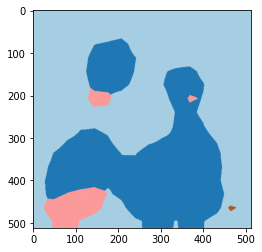

In [ ]:
colormap = plt.cm.get_cmap("Paired", 21)
colored_segmentation = colormap(out)
plt.imshow(colored_segmentation)

In [ ]:
image=io.imread('/content/drive/MyDrive/PascalVOC/trainval/Images/000332.jpg')
image=t(image)
image = pt.unsqueeze(image,dim=0)
out_img=model_1(image)
out=out_img.squeeze(0)
out = out.argmax(0)
out = out.numpy()


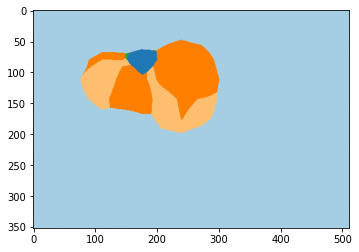

In [ ]:
colormap = plt.cm.get_cmap("Paired", 21)
colored_segmentation = colormap(out)
plt.imshow(colored_segmentation)

In [ ]:
image=io.imread('/content/drive/MyDrive/PascalVOC/trainval/Images/000123.jpg')
image=t(image)
image = pt.unsqueeze(image,dim=0)
out_img=model_1(image)
out=out_img.squeeze(0)
out = out.argmax(0)
out = out.numpy()


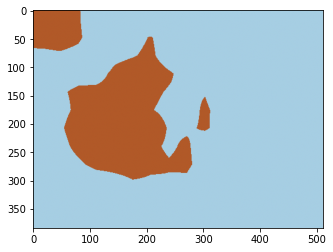

In [ ]:
colormap = plt.cm.get_cmap("Paired", 21)
colored_segmentation = colormap(out)
plt.imshow(colored_segmentation)

In [ ]:
image=io.imread('/content/drive/MyDrive/PascalVOC/trainval/Images/000768.jpg')
image=t(image)
image = pt.unsqueeze(image,dim=0)
out_img=model_1(image)
out=out_img.squeeze(0)
out = out.argmax(0)
out = out.numpy()


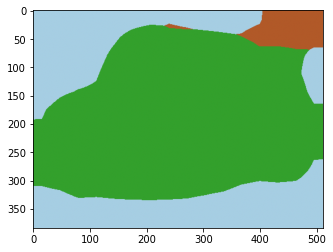

In [ ]:
colormap = plt.cm.get_cmap("Paired", 21)
colored_segmentation = colormap(out)
plt.imshow(colored_segmentation)

## Testing on evaluation dataset

In [ ]:
# Function to calculate IOU
num_classes = 21
def find_iou(pred, target, num_classes):
    ious = []
    for class_id in range(num_classes):
        intersection = (pred == class_id) & (target == class_id)
        union = (pred == class_id) | (target == class_id)
        if union.sum()!=0:
          iou = intersection.sum() / union.sum()
          ious.append(iou)
    return np.mean(ious)

In [ ]:
# model on test images
net_accs = []
net_iou = []
for i, (images, targets) in enumerate(validation_data_loader):
  out_img=model_1(images)
  out=out_img.squeeze(0)
  out = out.argmax(0)
  out = out.numpy()
  #print(out.max())
  targets = pt.squeeze(targets)
  ans = targets.numpy()
  acc = np.mean(out == ans)
  iou = find_iou(out,ans,21)
  net_accs.append(acc)
  net_iou.append(iou)


In [ ]:
np.mean(net_accs)

0.7602197351590009

In [ ]:
np.mean(net_iou)

0.39640423397536523

# Models that didnot work

In [ ]:
# class FCN(nn.Module):
#     def __init__(self, num_classes=21):
#       super(FCN, self).__init__()

#       ## Load the pretrained MobileNetV2 model
#       model1 = torchvision.models.mobilenet_v2(pretrained=True)
#       model1.features[18]=nn.Conv2d(320, num_classes, kernel_size=(1,1), stride=(1,1))
#       model1.classifier=nn.Conv2d(21, num_classes, kernel_size=(1,1), stride=(1,1))
#       self.modelss = model1

#       # Replace the last fully connected layer
#       #in_features = self.backbone.classifier[1].in_features
#       #self.backbone.classifier = nn.Conv2d(in_features, num_classes, kernel_size=1, stride=1)
#       #self.backbone.classifier = nn.Identity()

#       # Initialize the upsampling layers
#       self.deconv1=nn.ConvTranspose2d(21,num_classes,kernel_size = 8,stride=8)
#       self.deconv2=nn.ConvTranspose2d(num_classes,num_classes,kernel_size = 4,stride=4)
#       # self.deconv3=nn.ConvTranspose2d(num_classes,num_classes,kernel_size = 2,stride=2)
#       # self.deconv4=nn.ConvTranspose2d(num_classes,num_classes,kernel_size = 2,stride=2)
#       # self.deconv5=nn.ConvTranspose2d(num_classes,num_classes,kernel_size = 2,stride=2)

#     def forward(self, x):
#       #print(x.shape)
#       x = self.modelss(x)
  
#       #print(x.shape)
#       # x = self.deconv1(x)
#       # x = self.deconv2(x)
#       # x = self.deconv3(x)
#       # x = self.deconv4(x)
#       # x = self.deconv5(x)
#       #print(x.shape)

#       return x
# model = torchvision.models.mobilenet_v2(pretrained=True)
# print(list(model.features[18].children()))

In [34]:
class FCN(nn.Module):
    def __init__(self, num_classes=21):
      super(FCN, self).__init__()

      ## Load the pretrained MobileNetV2 model
      self.backbone = torchvision.models.mobilenet_v2(pretrained=True)

      # Replace the last fully connected layer
      #self.backbone.features[18]=nn.Conv2d(320, num_classes, kernel_size=(1,1), stride=(1,1))
      in_features = self.backbone.classifier[1].in_features
      self.backbone.classifier = nn.Conv2d(in_features, 320, kernel_size=1, stride=1)

      # Initialize the upsampling layers
      self.deconv1=nn.ConvTranspose2d(320,160,kernel_size = 2,stride=2)
      self.deconv2=nn.ConvTranspose2d(160,96,kernel_size = 2,stride=2)
      self.deconv3=nn.ConvTranspose2d(96,64,kernel_size = 2,stride=2)
      self.deconv4=nn.ConvTranspose2d(64,num_classes,kernel_size = 2,stride=2)
      self.deconv5=nn.ConvTranspose2d(num_classes,num_classes,kernel_size = 2,stride=2)

    def forward(self, x):
      #print(x.shape)
      x = self.backbone.features(x)
      x = self.backbone.classifier(x)
      #print(x.shape)
      x = self.deconv1(x)
      x = self.deconv2(x)
      x = self.deconv3(x)
      x = self.deconv4(x)
      x = self.deconv5(x)
      #print(x.shape)

      return x


In [ ]:
# class FCN(nn.Module):
#     def __init__(self, num_classes=21):
#       super(FCN, self).__init__()

#       ## Load the pretrained MobileNetV2 model
#       self.backbone = torchvision.models.mobilenet_v2(pretrained=True)

#       # Replace the last fully connected layer
#       in_features = self.backbone.classifier[1].in_features
#       self.backbone.classifier = nn.Conv2d(in_features, num_classes, kernel_size=1, stride=1)

#       # Initialize the upsampling layers
#       self.deconv1=nn.ConvTranspose2d(num_classes,num_classes,kernel_size = 8,stride=8)
#       self.deconv2=nn.ConvTranspose2d(num_classes,num_classes,kernel_size = 4,stride=4)
#       # self.deconv3=nn.ConvTranspose2d(num_classes,num_classes,kernel_size = 2,stride=2)
#       # self.deconv4=nn.ConvTranspose2d(num_classes,num_classes,kernel_size = 2,stride=2)
#       # self.deconv5=nn.ConvTranspose2d(num_classes,num_classes,kernel_size = 2,stride=2)

#     def forward(self, x):
#       #print(x.shape)
#       x = self.backbone.features(x)
#       x = self.backbone.classifier(x)
#       #print(x.shape)
#       x = self.deconv1(x)
#       x = self.deconv2(x)
#       # x = self.deconv3(x)
#       # x = self.deconv4(x)
#       # x = self.deconv5(x)
#       #print(x.shape)

#       return x


In [45]:
model = FCN()
model


FCN(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), s

In [46]:
for name, param in model.named_parameters():
    if 'deconv1' in name or 'classifier' in name or 'deconv2' in name or 'deconv3' in name or 'deconv4' in name or 'deconv5' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [37]:
summary(model,input_size=(32, 3, 448, 320),col_names=["input_size","num_params","output_size"])

Layer (type:depth-idx)                                  Input Shape               Param #                   Output Shape
FCN                                                     [32, 3, 448, 320]         --                        [32, 21, 448, 320]
├─MobileNetV2: 1-1                                      --                        --                        --
│    └─Sequential: 2-1                                  [32, 3, 448, 320]         --                        [32, 1280, 14, 10]
│    │    └─Conv2dNormActivation: 3-1                   [32, 3, 448, 320]         (928)                     [32, 32, 224, 160]
│    │    └─InvertedResidual: 3-2                       [32, 32, 224, 160]        (896)                     [32, 16, 224, 160]
│    │    └─InvertedResidual: 3-3                       [32, 16, 224, 160]        (5,136)                   [32, 24, 112, 80]
│    │    └─InvertedResidual: 3-4                       [32, 24, 112, 80]         (8,832)                   [32, 24, 112, 80]
│    │  

In [38]:
summary(model,col_names=["num_params", "trainable"])

Layer (type:depth-idx)                                  Param #                   Trainable
FCN                                                     --                        Partial
├─MobileNetV2: 1-1                                      --                        Partial
│    └─Sequential: 2-1                                  --                        False
│    │    └─Conv2dNormActivation: 3-1                   (928)                     False
│    │    └─InvertedResidual: 3-2                       (896)                     False
│    │    └─InvertedResidual: 3-3                       (5,136)                   False
│    │    └─InvertedResidual: 3-4                       (8,832)                   False
│    │    └─InvertedResidual: 3-5                       (10,000)                  False
│    │    └─InvertedResidual: 3-6                       (14,848)                  False
│    │    └─InvertedResidual: 3-7                       (14,848)                  False
│    │    └─InvertedResi

In [47]:
wt = pt.ones(21)
wt[0]=0.1

In [ ]:
from distutils.version import LooseVersion
import torch.nn.functional as F
def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)
    if LooseVersion(pt.__version__) < LooseVersion('0.3'):
        # ==0.2.X
        log_p = F.log_softmax(input)
    else:
        # >=0.3
        log_p = F.log_softmax(input, dim=1)
    # log_p: (n*h*w, c)
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target, weight=weight, reduction='sum')
    if size_average:
        loss /= mask.data.sum()
    return loss

In [ ]:
# criterion = cross_entropy2d
# optimizer = pt.optim.Adam(model.parameters(), lr=0.01)

In [48]:

criterion = nn.CrossEntropyLoss(weight = wt)
optimizer = pt.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epochs in range(0,12):
  loss = 0.0
  for i, (img,label) in enumerate(train_data_loader):
    #print(label.max())
    output = model(img)
    
    # _,predicted = pt.max(output.data, 1)
    # print(predicted.max())
    # print(predicted.min())
    #label=label.long()
    # print(label.max())
    # print(label.min())
    loss=criterion(output,label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss = loss + loss.item();
  #_,predicted = pt.max(output.data, 1)
  #print(predicted.max())
  print('epochs %d loss %.3f'%(epochs,loss/(epochs+1)))


In [ ]:
num_classes = 21
def find_iou(pred, target, num_classes):
    ious = []
    for class_id in range(num_classes):
        intersection = (pred == class_id) & (target == class_id)
        union = (pred == class_id) | (target == class_id)
        if union.sum()!=0:
          iou = intersection.sum() / union.sum()
          ious.append(iou)
    return np.mean(ious)

In [ ]:
net_accs = []
net_iou = []
for i, (images, targets) in enumerate(validation_data_loader):
  out_img=model(images)
  out=out_img.squeeze(0)
  out = out.argmax(0)
  out = out.numpy()
  #print(out.max())
  targets = pt.squeeze(targets)
  ans = targets.numpy()
  acc = np.mean(out == ans)
  iou = find_iou(out,ans,21)
  net_accs.append(acc)
  net_iou.append(iou)


In [ ]:
np.mean(net_accs)

0.06292134316314554

In [ ]:
np.mean(net_iou)

0.006187938185770246

In [ ]:
x=out_img.squeeze(0)

In [ ]:
x.shape

torch.Size([21, 352, 512])

In [ ]:
model.eval()

In [51]:
t =transforms.ToTensor()

In [52]:
image=io.imread('/content/drive/MyDrive/PascalVOC/trainval/Images/000676.jpg')
image=t(image)
image = pt.unsqueeze(image,dim=0)
out_img=model(image)
out=out_img.squeeze(0)
out = out.argmax(0)
out = out.numpy()


In [45]:
image=io.imread('/content/drive/MyDrive/PascalVOC/trainval/Images/000032.jpg')
image.shape

(281, 500, 3)

In [46]:
for i, (img,label) in enumerate(train_data_loader):
    #print(label.max())
    output = model(img)
    
    _,predicted = pt.max(output.data, 1)
    print(predicted.max())

tensor(20)
tensor(20)
tensor(20)
tensor(20)
tensor(20)
tensor(20)
tensor(20)


In [47]:
out.max()

20

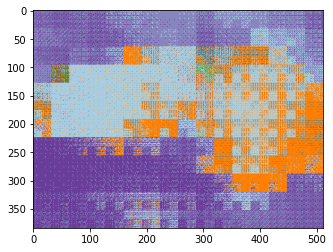

In [53]:
colormap = plt.cm.get_cmap("Paired", 21)
colored_segmentation = colormap(out)
plt.imshow(colored_segmentation)

In [ ]:
image = io.imread('/content/drive/MyDrive/PascalVOC/trainval/Images/000032.jpg')
annotation = io.imread('/content/drive/MyDrive/PascalVOC/trainval/Annotations/000032.png')
print(annotation.max())
annot = preprocess(annotation)
print(annot.max())
annot=annot.numpy()
print(annot)
annot = annot.transpose(1,2,0)
print(annot.shape)
annot = annot[:,:,:3]
mask = np.zeros_like(annot[:, :, 0])
print(mask.shape)
for label, color in PASCAL_VOC_CLASSES_COLORS.items():
  #print(label)
  #print(color)
  m = np.all(annot == color, axis=-1)

  mask[m] = label

In [ ]:
t = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
image = io.imread('/content/drive/MyDrive/PascalVOC/trainval/Images/000032.jpg')
annotation = io.imread('/content/drive/MyDrive/PascalVOC/trainval/Annotations/000032.png')
print(annotation.shape)
annot = preprocess(annotation)
print(annot.shape)

(281, 500, 4)
torch.Size([4, 224, 224])


In [ ]:
type(annotation)

numpy.ndarray

In [ ]:
annot=annot*255

In [ ]:
annot.astype(int).max()


224

In [ ]:
mask.max()

0.0